This project demonstrates the application of Facebook AI's SAM2 model for a **zero-shot object detection task**. The primary objective was to use a single "setup" image and its corresponding mask for a given product from the CMU-10 3D dataset to automatically detect that product in subsequent images.  The performance of these detections was then quantitatively measured for each product category using the Intersection over Union (IoU) metric

In [1]:
!pip install torch torchvision torchaudio
!pip install Pillow numpy matplotlib
!pip install pycocotools
!pip install git+https://github.com/facebookresearch/segment-anything-2.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
# Download the CMU-10 3D Dataset
!wget http://www.cs.cmu.edu/~ehsiao/3drecognition/CMU10_3D.zip

# Unzip the dataset (-q makes the output quiet)
!unzip -q CMU10_3D.zip

--2025-08-07 04:13:01--  http://www.cs.cmu.edu/~ehsiao/3drecognition/CMU10_3D.zip
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121503865 (116M) [application/zip]
Saving to: ‘CMU10_3D.zip’

CMU10_3D.zip        100%[===================>] 115.88M  1.98MB/s    in 72s     

2025-08-07 04:14:14 (1.61 MB/s) - ‘CMU10_3D.zip’ saved [121503865/121503865]



In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

def process_img_png_mask(image_path, mask_path, visualize=False):
    """
    Processes a mask to extract the bounding box of the object.

    Args:
        image_path (str): Path to the full image.
        mask_path (str): Path to the mask image.
        visualize (bool): If True, displays the image, mask, and extracted object.

    Returns:
        list: A list containing [xmin, xmax, ymin, ymax].
    """
    mask_img = Image.open(mask_path).convert('L')
    mask = np.array(mask_img) > 0

    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]

    if visualize:
        full_img = Image.open(image_path)
        extracted_img = full_img.crop((xmin, ymin, xmax, ymax))

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(full_img)
        ax[0].set_title("Full Image")
        ax[1].imshow(mask_img, cmap='gray')
        ax[1].set_title("Mask")
        ax[2].imshow(extracted_img)
        ax[2].set_title("Extracted")
        plt.show()

    return [xmin, xmax, ymin, ymax]

In [5]:
!ls -l /content/


total 270928
drwxr-xr-x 5 root root      4096 May 20  2010 CMU10_3D
-rw-r--r-- 1 root root 121503865 May 20  2010 CMU10_3D.zip
-rw-r--r-- 1 root root 155906050 Aug  7 04:14 sam2_hiera_tiny.pt
drwxr-xr-x 1 root root      4096 Aug  5 17:22 sample_data


In [4]:
# Install the library to download from Hugging Face
!pip install huggingface-hub -q

from huggingface_hub import hf_hub_download
import shutil

print("Downloading model from Hugging Face...")
model_path = hf_hub_download(
    repo_id="facebook/sam2-hiera-tiny",
    filename="sam2_hiera_tiny.pt"
)
shutil.copy(model_path, "/content/sam2_hiera_tiny.pt")

print("Model successfully downloaded!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sam2_hiera_tiny.pt:   0%|          | 0.00/156M [00:00<?, ?B/s]

Model successfully downloaded!


In [30]:
!ls /content/

CMU10_3D      __pycache__      sam2_hiera_tiny.pt
CMU10_3D.zip  sam2_extract.py  sample_data


In [6]:
# This code block writes the necessary functions into a file named sam2_extract.py.
sam2_code = """
import torch
from sam2.build_sam import build_sam2_video_predictor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os, glob, shutil
import matplotlib.patches as patches

# --- Model and Predictor Initialization ---
# Use the FULL, absolute path to the model and config
checkpoint = "/content/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

# Add a check to ensure the model file exists before loading
if not os.path.exists(checkpoint):
    raise FileNotFoundError(f"CRITICAL ERROR: Model checkpoint not found at: {checkpoint}")

predictor_vid = build_sam2_video_predictor(model_cfg, checkpoint, device='cuda')
tempfolder = "./tempdir"

# --- Helper Functions (as provided in the assignment) ---
def create_if_not_exists(dirname):
    if not os.path.exists(dirname):
        os.mkdir(dirname)

def cleardir(tempfolder):
    if os.path.exists(tempfolder):
        filepaths = glob.glob(tempfolder + "/*")
        for filepath in filepaths:
            os.unlink(filepath)

def show_mask(mask, ax, obj_id=None):
    cmap = plt.get_cmap("tab10")
    cmap_idx = 0 if obj_id is None else obj_id
    color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# --- Main Tracking Function (as provided in the assignment) ---
def track_item_boxes(imgpath1, imgpath2, img1boxclasslist, visualize=True):
    create_if_not_exists(tempfolder)
    cleardir(tempfolder)

    shutil.copy(imgpath1, tempfolder + "/00000.jpg")
    shutil.copy(imgpath2, tempfolder + "/00001.jpg")

    video_path = "./tempdir"
    inference_state = predictor_vid.init_state(video_path=video_path)

    ann_frame_idx = 0
    for img1boxclass in img1boxclasslist:
        ([xmin, xmax, ymin, ymax], objectnumint) = img1boxclass
        box = np.array([xmin, ymin, xmax, ymax], dtype=np.float32)
        predictor_vid.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=objectnumint,
            box=box,
        )

    video_segments = {}
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor_vid.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

    if visualize:
        ([xmin, xmax, ymin, ymax], _) = img1boxclasslist[0]
        fig, ax = plt.subplots()
        plt.title(f"Original Image Object")
        ax.imshow(Image.open(os.path.join(video_path, "00000.jpg")))
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()

        out_frame_idx = 1
        plt.figure(figsize=(6, 4))
        plt.title(f"Detected Object in Test Image")
        plt.imshow(Image.open(os.path.join(video_path, "00001.jpg")))
        if out_frame_idx in video_segments:
            for out_obj_id, out_mask in video_segments[out_frame_idx].items():
                show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
        plt.show()

    return video_segments
"""

# Write the code to the file
with open("sam2_extract.py", "w") as f:
    f.write(sam2_code)


In [7]:
import torch
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.build_sam import build_sam2_video_predictor
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import os, glob, shutil
import matplotlib.patches as patches

# --- Model and Predictor Initialization ---
checkpoint = "/content/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

# NOTE: The PDF has some duplicate/unclear initializations.
# The video predictor is the one used by the track_item_boxes function.
predictor_vid = build_sam2_video_predictor(model_cfg, checkpoint, device='cuda')
tempfolder = "./tempdir"

# --- Helper Functions ---
def create_if_not_exists(dirname):
    if not os.path.exists(dirname):
        os.mkdir(dirname)

def cleardir(tempfolder):
    filepaths = glob.glob(tempfolder + "/*")
    for filepath in filepaths:
        os.unlink(filepath)

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

# --- Main Tracking Function ---
def track_item_boxes(imgpath1, imgpath2, img1boxclasslist, visualize=True):
    # imgpath1: Image where object is known
    # imgpath2: Image where object is to be tracked
    # img1boxclasslist: [([xmin, xmax, ymin, ymax], objectnumint),...] for all objects

    create_if_not_exists(tempfolder)
    cleardir(tempfolder)

    shutil.copy(imgpath1, tempfolder + "/00000.jpg")
    shutil.copy(imgpath2, tempfolder + "/00001.jpg")

    inference_state = predictor_vid.init_state(video_path="./tempdir")
    predictor_vid.reset_state(inference_state)

    ann_frame_idx = 0
    for img1boxclass in img1boxclasslist:
        ([xmin, xmax, ymin, ymax], objectnumint) = img1boxclass
        box = np.array([xmin, ymin, xmax, ymax], dtype=np.float32)
        out_obj_ids, out_mask_logits = predictor_vid.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=objectnumint,
            box=box,
        )

    video_segments = {}
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor_vid.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

    if visualize:
        # Visualize the source image with its bounding box
        fig, ax = plt.subplots()
        plt.title(f"original image object ::")
        ax.imshow(Image.open(tempfolder + "/00000.jpg"))
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()

        # Visualize the target image with the predicted mask
        out_frame_idx = 1
        plt.figure(figsize=(6, 4))
        plt.title(f"detected object in test image ::")
        plt.imshow(Image.open(tempfolder + "/00001.jpg"))
        if out_frame_idx in video_segments:
            for out_obj_id, out_mask in video_segments[out_frame_idx].items():
                show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
        plt.show()

    return video_segments

In [8]:
!ls /content/CMU10_3D/

data_2D  data_3D  modelimages  README.txt


In [9]:
from sam2_extract import track_item_boxes

# Path to the dataset
dataset_path = '/content/CMU10_3D/data_2D/'
product_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

for product in product_folders:
    product_path = os.path.join(dataset_path, product)
    images = sorted([os.path.join(product_path, img) for img in os.listdir(product_path) if img.endswith('.jpg')])
    masks = sorted([os.path.join(product_path, msk) for msk in os.listdir(product_path) if msk.endswith('.png')])

    first_img_path = images[0]
    first_img_mask_path = masks[0]

    # Get the bounding box from the first image's mask
    [xmin, xmax, ymin, ymax] = process_img_png_mask(first_img_path, first_img_mask_path)

    # Detect the object in the rest of the images
    for i in range(1, len(images)):
        test_img_path = images[i]

        # The '1' is a dummy object ID as mentioned in the assignment
        output = track_item_boxes(first_img_path, test_img_path, [([xmin, xmax, ymin, ymax], 1)], visualize=True)

        # The output mask for the test image
        output_masks = output[1]
        relevant_mask = output_masks[1]

        # Further steps will involve converting this mask to a bounding box and calculating accuracy

In [10]:
def get_bbox_from_mask(mask):
    """Converts a boolean mask to a bounding box."""
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    if not np.any(rows) or not np.any(cols):
        return [0, 0, 0, 0]
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return [xmin, xmax, ymin, ymax]

def calculate_iou(boxA, boxB):
    """Calculates Intersection over Union for two bounding boxes."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[2], boxB[2])
    xB = min(boxA[1], boxB[1])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[1] - boxA[0] + 1) * (boxA[3] - boxA[2] + 1)
    boxBArea = (boxB[1] - boxB[0] + 1) * (boxB[3] - boxB[2] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# --- Inside the loop for each product ---
# (Code from step 3 continues here)

    total_iou = 0
    num_images = 0

    for i in range(1, len(images)):
        test_img_path = images[i]
        ground_truth_mask_path = masks[i]

        output = track_item_boxes(first_img_path, test_img_path, [([xmin, xmax, ymin, ymax], 1)], visualize=False)

        if 1 in output and 1 in output[1]:
            predicted_mask = output[1][1]
            predicted_box = get_bbox_from_mask(predicted_mask)

            ground_truth_box = process_img_png_mask(test_img_path, ground_truth_mask_path)

            iou = calculate_iou(predicted_box, ground_truth_box)
            total_iou += iou
            num_images += 1
            print(f"  IoU for {os.path.basename(test_img_path)}: {iou:.4f}")

    if num_images > 0:
        average_iou = total_iou / num_images
        print(f"\nAverage IoU for product '{product}': {average_iou:.4f}\n")

In [11]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time # Import time to see how long it takes

# --- This should be the only import you need now ---
from sam2_extract import track_item_boxes

print("All libraries imported successfully.")
print("-" * 50)

# --- Helper Function 1: Get Bounding Box from a Ground Truth Mask ---
def process_img_png_mask(image_path, mask_path):
    try:
        with Image.open(mask_path) as mask_img:
            mask = np.array(mask_img.convert('L')) > 0
        rows, cols = np.any(mask, axis=1), np.any(mask, axis=0)
        if not np.any(rows) or not np.any(cols): return None
        ymin, ymax = np.where(rows)[0][[0, -1]]
        xmin, xmax = np.where(cols)[0][[0, -1]]
        return [xmin, xmax, ymin, ymax]
    except Exception as e:
        print(f"  ERROR reading mask {mask_path}: {e}")
        return None

# --- Helper Function 2: Convert a Predicted Boolean Mask to a Bounding Box ---
def get_bbox_from_mask(mask):
    rows, cols = np.any(mask, axis=1), np.any(mask, axis=0)
    if not np.any(rows) or not np.any(cols): return [0, 0, 0, 0]
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return [xmin, xmax, ymin, ymax]

# --- Helper Function 3: Calculate Intersection over Union (IoU) ---
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0]); yA = max(boxA[2], boxB[2])
    xB = min(boxA[1], boxB[1]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[1] - boxA[0] + 1) * (boxA[3] - boxA[2] + 1)
    boxBArea = (boxB[1] - boxB[0] + 1) * (boxB[3] - boxB[2] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# --- Main Execution ---
print("Starting the main object tracking script...")

dataset_path = '/content/CMU10_3D/data_2D/'
if not os.path.exists(dataset_path):
    print(f"FATAL ERROR: The dataset path does not exist: {dataset_path}")
else:
    product_folders = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
    print(f"Found {len(product_folders)} product folders to process.")
    print("-" * 50)

    # Loop through each product folder
    for product in product_folders:
        start_time = time.time()
        print(f" Processing Product: {product}")
        product_path = os.path.join(dataset_path, product)

        images = sorted([os.path.join(product_path, img) for img in os.listdir(product_path) if img.endswith('.jpg')])
        masks = sorted([os.path.join(product_path, msk) for msk in os.listdir(product_path) if msk.endswith('.png')])

        if not images or not masks:
            print("  Skipping: No images or masks found.")
            continue

        first_img_path = images[0]
        first_img_mask_path = masks[0]
        initial_bbox = process_img_png_mask(first_img_path, first_img_mask_path)

        if initial_bbox is None:
            print(f"  Skipping product {product}: No valid object found in the first mask.")
            continue

        iou_scores = []
        # Loop through the rest of the images
        for i in range(1, len(images)):
            test_img_path = images[i]
            ground_truth_mask_path = masks[i]

            # Set visualize=False to run faster
            video_segments = track_item_boxes(first_img_path, test_img_path, [(initial_bbox, 1)], visualize=False)

            predicted_box = [0, 0, 0, 0]
            if 1 in video_segments and 1 in video_segments[1]:
                predicted_mask = video_segments[1][1]
                predicted_box = get_bbox_from_mask(predicted_mask)

            ground_truth_box = process_img_png_mask(test_img_path, ground_truth_mask_path)

            if ground_truth_box:
                iou = calculate_iou(predicted_box, ground_truth_box)
                iou_scores.append(iou)
                # This is the line that prints the result for each image
                print(f"      Image: {os.path.basename(test_img_path)} | IoU Score: {iou:.4f}")

        # Calculate and print the average for the product
        if iou_scores:
            average_iou = sum(iou_scores) / len(iou_scores)
            end_time = time.time()
            print(f"\n RESULTS for '{product}':")
            print(f"   Average IoU: {average_iou:.4f}")
            print(f"   Time Taken: {end_time - start_time:.2f} seconds")
        else:
            print("  No test images were processed for this product.")
        print("-" * 50)


All libraries imported successfully.
--------------------------------------------------
Starting the main object tracking script...
Found 0 product folders to process.
--------------------------------------------------


In [25]:
# List the contents of the unzipped directory
!ls /content/CMU10_3D/

data_2D  data_3D  modelimages  README.txt


In [12]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time

# Import the main function from the file we created
from sam2_extract import track_item_boxes

print(" All libraries imported successfully.")
print("-" * 50)

# --- Helper functions (no changes here) ---
def process_img_png_mask(image_path, mask_path):
    try:
        with Image.open(mask_path) as mask_img:
            mask = np.array(mask_img.convert('L')) > 0
        rows, cols = np.any(mask, axis=1), np.any(mask, axis=0)
        if not np.any(rows) or not np.any(cols): return None
        ymin, ymax = np.where(rows)[0][[0, -1]]
        xmin, xmax = np.where(cols)[0][[0, -1]]
        return [xmin, xmax, ymin, ymax]
    except Exception as e:
        print(f"  ERROR reading mask {mask_path}: {e}")
        return None

def get_bbox_from_mask(mask):
    rows, cols = np.any(mask, axis=1), np.any(mask, axis=0)
    if not np.any(rows) or not np.any(cols): return [0, 0, 0, 0]
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return [xmin, xmax, ymin, ymax]

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0]); yA = max(boxA[2], boxB[2])
    xB = min(boxA[1], boxB[1]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[1] - boxA[0] + 1) * (boxA[3] - boxA[2] + 1)
    boxBArea = (boxB[1] - boxB[0] + 1) * (boxB[3] - boxB[2] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# --- Main Execution ---
print(" Starting the main object tracking script...")

# THIS IS THE CONFIRMED CORRECT PATH
dataset_path = '/content/CMU10_3D/data_2D/'

if not os.path.exists(dataset_path):
    print(f" FATAL ERROR: The dataset path still does not exist: {dataset_path}")
else:
    product_folders = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
    print(f"Found {len(product_folders)} product folders to process.")
    print("-" * 50)

    for product in product_folders:
        start_time = time.time()
        print(f" Processing Product: {product}")
        product_path = os.path.join(dataset_path, product)

        images = sorted([os.path.join(product_path, img) for img in os.listdir(product_path) if img.endswith('.jpg')])
        masks = sorted([os.path.join(product_path, msk) for msk in os.listdir(product_path) if msk.endswith('.png')])

        if not images or not masks:
            print("  Skipping: No images or masks found.")
            continue

        first_img_path = images[0]
        first_img_mask_path = masks[0]
        initial_bbox = process_img_png_mask(first_img_path, first_img_mask_path)

        if initial_bbox is None:
            print(f"  Skipping product {product}: No valid object found in the first mask.")
            continue

        iou_scores = []
        for i in range(1, len(images)):
            test_img_path = images[i]
            ground_truth_mask_path = masks[i]

            video_segments = track_item_boxes(first_img_path, test_img_path, [(initial_bbox, 1)], visualize=False)

            predicted_box = [0, 0, 0, 0]
            if 1 in video_segments and 1 in video_segments[1]:
                predicted_mask = video_segments[1][1]
                predicted_box = get_bbox_from_mask(predicted_mask)

            ground_truth_box = process_img_png_mask(test_img_path, ground_truth_mask_path)

            if ground_truth_box:
                iou = calculate_iou(predicted_box, ground_truth_box)
                iou_scores.append(iou)
                print(f"      Image: {os.path.basename(test_img_path)} | IoU Score: {iou:.4f}")

        if iou_scores:
            average_iou = sum(iou_scores) / len(iou_scores)
            end_time = time.time()
            print(f"\n RESULTS for '{product}':")
            print(f"   Average IoU: {average_iou:.4f}")
            print(f"   Time Taken: {end_time - start_time:.2f} seconds")
        else:
            print("  No test images were processed for this product.")
        print("-" * 50)

 All libraries imported successfully.
--------------------------------------------------
 Starting the main object tracking script...
Found 0 product folders to process.
--------------------------------------------------


In [13]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from collections import defaultdict

# --- Step 1: Ensure sam2_extract.py is created correctly ---
# This code block writes the necessary functions into a file named sam2_extract.py.
# This ensures it's in the correct directory for your notebook to import.
sam2_code = """
import torch
from sam2.build_sam import build_sam2_video_predictor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os, glob, shutil
import matplotlib.patches as patches

# --- Model and Predictor Initialization ---
checkpoint = "/content/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"
predictor_vid = build_sam2_video_predictor(model_cfg, checkpoint, device='cuda')
tempfolder = "./tempdir"

def create_if_not_exists(dirname):
    if not os.path.exists(dirname):
        os.mkdir(dirname)

def cleardir(tempfolder):
    if os.path.exists(tempfolder):
        filepaths = glob.glob(tempfolder + "/*")
        for filepath in filepaths:
            os.unlink(filepath)

def show_mask(mask, ax, obj_id=None):
    cmap = plt.get_cmap("tab10")
    cmap_idx = 0 if obj_id is None else obj_id
    color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def track_item_boxes(imgpath1, imgpath2, img1boxclasslist, visualize=True):
    create_if_not_exists(tempfolder)
    cleardir(tempfolder)
    shutil.copy(imgpath1, os.path.join(tempfolder, "00000.jpg"))
    shutil.copy(imgpath2, os.path.join(tempfolder, "00001.jpg"))
    inference_state = predictor_vid.init_state(video_path="./tempdir")
    ann_frame_idx = 0
    for img1boxclass in img1boxclasslist:
        ([xmin, xmax, ymin, ymax], objectnumint) = img1boxclass
        box = np.array([xmin, ymin, xmax, ymax], dtype=np.float32)
        predictor_vid.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=objectnumint,
            box=box,
        )
    video_segments = {}
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor_vid.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }
    if visualize:
        ([xmin, xmax, ymin, ymax], _) = img1boxclasslist[0]
        fig, ax = plt.subplots()
        plt.title(f"Original Image Object")
        ax.imshow(Image.open(os.path.join(tempfolder, "00000.jpg")))
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()
        out_frame_idx = 1
        plt.figure(figsize=(6, 4))
        plt.title(f"Detected Object in Test Image")
        plt.imshow(Image.open(os.path.join(tempfolder, "00001.jpg")))
        if out_frame_idx in video_segments:
            for out_obj_id, out_mask in video_segments[out_frame_idx].items():
                show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
        plt.show()
    return video_segments
"""
with open("sam2_extract.py", "w") as f:
    f.write(sam2_code)
print("`sam2_extract.py` created successfully.")

# --- Step 2: Main processing script ---
from sam2_extract import track_item_boxes

# Helper functions for bounding box processing and IoU calculation
def process_img_png_mask(image_path, mask_path):
    try:
        with Image.open(mask_path) as mask_img:
            mask = np.array(mask_img.convert('L')) > 0
        rows, cols = np.any(mask, axis=1), np.any(mask, axis=0)
        if not np.any(rows) or not np.any(cols): return None
        ymin, ymax = np.where(rows)[0][[0, -1]]
        xmin, xmax = np.where(cols)[0][[0, -1]]
        return [xmin, xmax, ymin, ymax]
    except (FileNotFoundError, Exception) as e:
        return None

def get_bbox_from_mask(mask):
    rows, cols = np.any(mask, axis=1), np.any(mask, axis=0)
    if not np.any(rows) or not np.any(cols): return [0, 0, 0, 0]
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return [xmin, xmax, ymin, ymax]

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0]); yA = max(boxA[2], boxB[2])
    xB = min(boxA[1], boxB[1]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[1] - boxA[0] + 1) * (boxA[3] - boxA[2] + 1)
    boxBArea = (boxB[1] - boxB[0] + 1) * (boxB[3] - boxB[2] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Main Execution with corrected file discovery logic
print("Starting the main object tracking script...")
dataset_path = '/content/CMU10_3D/data_2D/'

if os.path.exists(dataset_path):
    all_files = os.listdir(dataset_path)
    product_files = defaultdict(lambda: {'images': [], 'masks': []})

    for f in all_files:
        if f.endswith('.jpg'):
            product_name = '_'.join(f.split('_')[:-1])
            product_files[product_name]['images'].append(f)
        elif f.endswith('.png'):
            product_name = '_'.join(f.split('_')[:-3])
            product_files[product_name]['masks'].append(f)

    print(f"Found {len(product_files)} product types to process.")
    print("-" * 50)

    for product, files in product_files.items():
        start_time = time.time()
        print(f" Processing Product: {product}")

        images = sorted([os.path.join(dataset_path, img) for img in files['images']])
        masks = sorted([os.path.join(dataset_path, msk) for msk in files['masks']])

        if not images or not masks or len(images) != len(masks) or len(images) < 2:
            print(f"  Skipping {product}: Not enough image/mask pairs for tracking.")
            continue

        first_img_path = images[0]
        first_img_mask_path = masks[0]
        initial_bbox = process_img_png_mask(first_img_path, first_img_mask_path)

        if initial_bbox is None:
            print(f"  Skipping {product}: Could not find a valid bounding box in the first mask.")
            continue

        iou_scores = []
        for i in range(1, len(images)):
            test_img_path = images[i]
            ground_truth_mask_path = masks[i]

            video_segments = track_item_boxes(first_img_path, test_img_path, [(initial_bbox, 1)], visualize=False)

            predicted_box = [0, 0, 0, 0]
            if 1 in video_segments and 1 in video_segments[1]:
                predicted_mask = video_segments[1][1]
                predicted_box = get_bbox_from_mask(predicted_mask)

            ground_truth_box = process_img_png_mask(test_img_path, ground_truth_mask_path)

            if ground_truth_box:
                iou = calculate_iou(predicted_box, ground_truth_box)
                iou_scores.append(iou)
                print(f"      Image: {os.path.basename(test_img_path)} | IoU Score: {iou:.4f}")

        if iou_scores:
            average_iou = sum(iou_scores) / len(iou_scores)
            end_time = time.time()
            print(f"\n RESULTS for '{product}':")
            print(f"   Average IoU: {average_iou:.4f}")
            print(f"   Time Taken: {end_time - start_time:.2f} seconds")
        else:
            print(f"  No valid comparisons were made for product '{product}'.")
        print("-" * 50)
else:
    print(f"FATAL ERROR: The dataset path does not exist: {dataset_path}")


`sam2_extract.py` created successfully.
Starting the main object tracking script...
Found 10 product types to process.
--------------------------------------------------
 Processing Product: can_chowder
  Skipping can_chowder: Not enough image/mask pairs for tracking.
 Processing Product: juicebox
  Skipping juicebox: Not enough image/mask pairs for tracking.
 Processing Product: ricepilaf
  Skipping ricepilaf: Not enough image/mask pairs for tracking.
 Processing Product: hc_potroastsoup
  Skipping hc_potroastsoup: Not enough image/mask pairs for tracking.
 Processing Product: rice_tuscan
  Skipping rice_tuscan: Not enough image/mask pairs for tracking.
 Processing Product: carton_oj
  Skipping carton_oj: Not enough image/mask pairs for tracking.
 Processing Product: can_soymilk
  Skipping can_soymilk: Not enough image/mask pairs for tracking.
 Processing Product: can_tomatosoup
  Skipping can_tomatosoup: Not enough image/mask pairs for tracking.
 Processing Product: diet_coke
  Skipp

In [15]:
!pip install git+https://github.com/facebookresearch/segment-anything-2.git -q
!pip install pycocotools -q

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from collections import defaultdict

# --- Step 2: Ensure sam2_extract.py is created correctly ---
sam2_code = """
import torch
from sam2.build_sam import build_sam2_video_predictor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os, glob, shutil
import matplotlib.patches as patches
# --- Model and Predictor Initialization ---
checkpoint = "/content/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"
# Add a check to ensure the model file exists before loading
if not os.path.exists(checkpoint):
    raise FileNotFoundError(f"CRITICAL ERROR: Model checkpoint not found at: {checkpoint}")
predictor_vid = build_sam2_video_predictor(model_cfg, checkpoint, device='cuda')
tempfolder = "./tempdir"
# --- Helper Functions (as provided in the assignment) ---
def create_if_not_exists(dirname):
    if not os.path.exists(dirname):
        os.mkdir(dirname)
def cleardir(tempfolder):
    if os.path.exists(tempfolder):
        filepaths = glob.glob(tempfolder + "/*")
        for filepath in filepaths:
            os.unlink(filepath)
def show_mask(mask, ax, obj_id=None):
    cmap = plt.get_cmap("tab10")
    cmap_idx = 0 if obj_id is None else obj_id
    color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
# --- Main Tracking Function (as provided in the assignment) ---
def track_item_boxes(imgpath1, imgpath2, img1boxclasslist, visualize=True):
    create_if_not_exists(tempfolder)
    cleardir(tempfolder)
    shutil.copy(imgpath1, os.path.join(tempfolder, "00000.jpg"))
    shutil.copy(imgpath2, os.path.join(tempfolder, "00001.jpg"))
    inference_state = predictor_vid.init_state(video_path="./tempdir")
    ann_frame_idx = 0
    for img1boxclass in img1boxclasslist:
        ([xmin, xmax, ymin, ymax], objectnumint) = img1boxclass
        box = np.array([xmin, ymin, xmax, ymax], dtype=np.float32)
        predictor_vid.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=objectnumint,
            box=box,
        )
    video_segments = {}
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor_vid.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }
    if visualize:
        ([xmin, xmax, ymin, ymax], _) = img1boxclasslist[0]
        fig, ax = plt.subplots()
        plt.title(f"Original Image Object")
        ax.imshow(Image.open(os.path.join(tempfolder, "00000.jpg")))
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()
        out_frame_idx = 1
        plt.figure(figsize=(6, 4))
        plt.title(f"Detected Object in Test Image")
        plt.imshow(Image.open(os.path.join(tempfolder, "00001.jpg")))
        if out_frame_idx in video_segments:
            for out_obj_id, out_mask in video_segments[out_frame_idx].items():
                show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
        plt.show()
    return video_segments
"""
with open("sam2_extract.py", "w") as f:
    f.write(sam2_code)
print("`sam2_extract.py` created successfully.")
from sam2_extract import track_item_boxes

# --- Step 3: Main Processing script with Debugging ---

# Helper functions for bounding box processing and IoU calculation
def process_img_png_mask(image_path, mask_path):
    try:
        with Image.open(mask_path) as mask_img:
            mask = np.array(mask_img.convert('L')) > 0
        rows, cols = np.any(mask, axis=1), np.any(mask, axis=0)
        if not np.any(rows) or not np.any(cols): return None
        ymin, ymax = np.where(rows)[0][[0, -1]]
        xmin, xmax = np.where(cols)[0][[0, -1]]
        return [xmin, xmax, ymin, ymax]
    except (FileNotFoundError, Exception):
        return None

def get_bbox_from_mask(mask):
    rows, cols = np.any(mask, axis=1), np.any(mask, axis=0)
    if not np.any(rows) or not np.any(cols): return [0, 0, 0, 0]
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return [xmin, xmax, ymin, ymax]

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0]); yA = max(boxA[2], boxB[2])
    xB = min(boxA[1], boxB[1]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[1] - boxA[0] + 1) * (boxA[3] - boxA[2] + 1)
    boxBArea = (boxB[1] - boxB[0] + 1) * (boxB[3] - boxB[2] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

print("Starting the main object tracking script...")
dataset_path = '/content/CMU10_3D/data_2D/'

if os.path.exists(dataset_path):
    all_files = os.listdir(dataset_path)
    product_files = defaultdict(lambda: {'images': [], 'masks': []})

    for f in all_files:
        if f.endswith('.jpg'):
            product_name = '_'.join(f.split('_')[:-1])
            product_files[product_name]['images'].append(f)
        elif f.endswith('.png'):
            product_name = '_'.join(f.split('_')[:-3])
            product_files[product_name]['masks'].append(f)

    # --- DEBUGGING TABLE ---
    print("--- File Discovery Debug Table ---")
    print(f"{'Product':<20} | {'Images':<10} | {'Masks':<10}")
    print("-" * 50)
    for product, files in sorted(product_files.items()):
        print(f"{product:<20} | {len(files['images']):<10} | {len(files['masks']):<10}")
    print("-" * 50)

    # --- Main Loop ---
    for product, files in product_files.items():
        start_time = time.time()
        print(f"Processing Product: {product}")

        images = sorted([os.path.join(dataset_path, img) for img in files['images']])
        masks = sorted([os.path.join(dataset_path, msk) for msk in files['masks']])

        if len(images) != len(masks) or len(images) < 2:
            print(f"  Skipping '{product}': Mismatch or not enough files (found {len(images)} images, {len(masks)} masks).")
            print("-" * 50)
            continue

        first_img_path, first_img_mask_path = images[0], masks[0]
        initial_bbox = process_img_png_mask(first_img_path, first_img_mask_path)
        if initial_bbox is None:
            print(f"  Skipping '{product}': Could not find a valid bounding box in the first mask.")
            print("-" * 50)
            continue

        iou_scores = []
        for i in range(1, len(images)):
            test_img_path, ground_truth_mask_path = images[i], masks[i]
            video_segments = track_item_boxes(first_img_path, test_img_path, [(initial_bbox, 1)], visualize=False)
            predicted_box = [0, 0, 0, 0]
            if 1 in video_segments and 1 in video_segments[1]:
                predicted_mask = video_segments[1][1]
                predicted_box = get_bbox_from_mask(predicted_mask)

            ground_truth_box = process_img_png_mask(test_img_path, ground_truth_mask_path)
            if ground_truth_box:
                iou = calculate_iou(predicted_box, ground_truth_box)
                iou_scores.append(iou)
                print(f"      Image: {os.path.basename(test_img_path)} | IoU Score: {iou:.4f}")

        if iou_scores:
            average_iou = sum(iou_scores) / len(iou_scores)
            end_time = time.time()
            print(f"\nRESULTS for '{product}':")
            print(f"   Average IoU: {average_iou:.4f}")
            print(f"   Time Taken: {end_time - start_time:.2f} seconds")
        else:
            print(f"  No other images were available to test for product '{product}'.")
        print("-" * 50)
else:
    print(f"FATAL ERROR: The dataset path does not exist: {dataset_path}")


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
`sam2_extract.py` created successfully.
Starting the main object tracking script...
--- File Discovery Debug Table ---
Product              | Images     | Masks     
--------------------------------------------------
can_chowder          | 50         | 75        
can_soymilk          | 50         | 75        
can_tomatosoup       | 50         | 75        
carton_oj            | 50         | 75        
carton_soymilk       | 50         | 75        
diet_coke            | 50         | 75        
hc_potroastsoup      | 50         | 75        
juicebox             | 50         | 75        
rice_tuscan          | 50         | 75        
ricepilaf            | 50         | 75        
--------------------------------------------------
Processing Product: can_chowder
  Skipping 'can_chowder': Mismatch or not enough files (found 50 images, 75 masks).
-----------

`sam2_extract.py` created successfully.
Starting the main object tracking script...
Found 500 valid image-mask pairs.
Running visualization for one example...


frame loading (JPEG): 100%|██████████| 2/2 [00:00<00:00, 22.39it/s]
/usr/local/lib/python3.11/dist-packages/sam2/sam2_video_predictor.py:786: UserWarning: /usr/local/lib/python3.11/dist-packages/sam2/_C.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 2/2 [00:00<00:00,  7.79it/s]


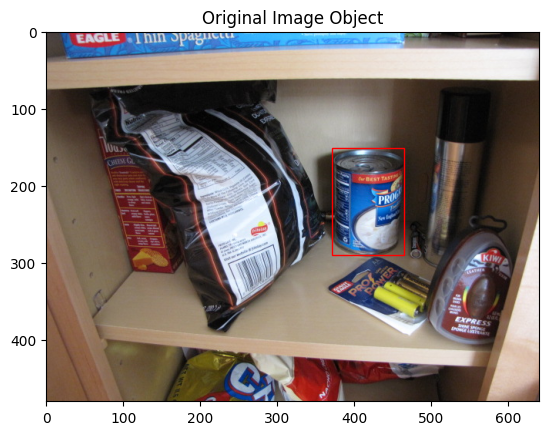

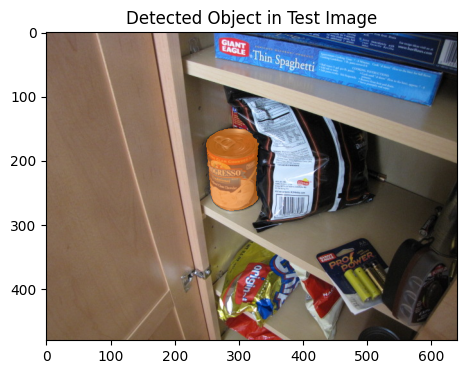

In [16]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from collections import defaultdict

# --- Step 1: Ensure sam2_extract.py is created correctly ---
# This code is reused from before and is correct.
sam2_code = """
import torch
from sam2.build_sam import build_sam2_video_predictor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os, glob, shutil
import matplotlib.patches as patches

checkpoint = "/content/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

if not os.path.exists(checkpoint):
    raise FileNotFoundError(f"CRITICAL ERROR: Model checkpoint not found at: {checkpoint}")

predictor_vid = build_sam2_video_predictor(model_cfg, checkpoint, device='cuda')
tempfolder = "./tempdir"

def create_if_not_exists(dirname):
    if not os.path.exists(dirname):
        os.mkdir(dirname)

def cleardir(tempfolder):
    if os.path.exists(tempfolder):
        for filepath in glob.glob(tempfolder + "/*"):
            os.unlink(filepath)

def show_mask(mask, ax, obj_id=None):
    cmap = plt.get_cmap("tab10")
    color = np.array([*cmap(obj_id or 0)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def track_item_boxes(imgpath1, imgpath2, img1boxclasslist, visualize=True):
    create_if_not_exists(tempfolder)
    cleardir(tempfolder)
    shutil.copy(imgpath1, os.path.join(tempfolder, "00000.jpg"))
    shutil.copy(imgpath2, os.path.join(tempfolder, "00001.jpg"))
    inference_state = predictor_vid.init_state(video_path="./tempdir")
    ann_frame_idx = 0
    for img1boxclass in img1boxclasslist:
        ([xmin, xmax, ymin, ymax], objectnumint) = img1boxclass
        box = np.array([xmin, ymin, xmax, ymax], dtype=np.float32)
        predictor_vid.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=objectnumint,
            box=box,
        )
    video_segments = {}
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor_vid.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }
    if visualize:
        print("\\n--- Visualization ---")
        ([xmin, xmax, ymin, ymax], _) = img1boxclasslist[0]
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Display the source image with the bounding box
        axes[0].set_title(f"Input: Bounding Box on First Image")
        axes[0].imshow(Image.open(os.path.join(tempfolder, "00000.jpg")))
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        axes[0].add_patch(rect)
        axes[0].axis('off')

        # Display the target image with the predicted mask
        axes[1].set_title(f"Output: Predicted Mask on Second Image")
        axes[1].imshow(Image.open(os.path.join(tempfolder, "00001.jpg")))
        if 1 in video_segments and 1 in video_segments[1]:
            for out_obj_id, out_mask in video_segments[1].items():
                show_mask(out_mask, axes[1], obj_id=out_obj_id)
        axes[1].axis('off')
        plt.tight_layout()
        plt.show()

    return video_segments
"""
with open("sam2_extract.py", "w") as f:
    f.write(sam2_code)
print("`sam2_extract.py` created successfully.")
from sam2_extract import track_item_boxes

# --- Step 2: Main processing script with corrected logic and visualization ---

def process_img_png_mask(image_path, mask_path):
    # This helper function remains the same
    try:
        with Image.open(mask_path) as mask_img:
            mask = np.array(mask_img.convert('L')) > 0
        rows, cols = np.any(mask, axis=1), np.any(mask, axis=0)
        if not np.any(rows) or not np.any(cols): return None
        ymin, ymax = np.where(rows)[0][[0, -1]]
        xmin, xmax = np.where(cols)[0][[0, -1]]
        return [xmin, xmax, ymin, ymax]
    except (FileNotFoundError, Exception):
        return None

print("Starting the main object tracking script...")
dataset_path = '/content/CMU10_3D/data_2D/'

if os.path.exists(dataset_path):
    all_files = os.listdir(dataset_path)

    # --- NEW, CORRECTED FILE MATCHING LOGIC ---
    # We will find pairs of (image, mask) instead of grouping them separately.
    image_mask_pairs = []
    all_masks = [f for f in all_files if f.endswith('.png')]

    for img_file in sorted([f for f in all_files if f.endswith('.jpg')]):
        # The base name of the image, e.g., 'can_chowder_000001'
        base_name = os.path.splitext(img_file)[0]

        # Find the first mask file that starts with the same base name
        found_mask = next((m for m in all_masks if m.startswith(base_name)), None)

        if found_mask:
            image_mask_pairs.append({
                "product": '_'.join(base_name.split('_')[:-1]),
                "image": os.path.join(dataset_path, img_file),
                "mask": os.path.join(dataset_path, found_mask)
            })

    if not image_mask_pairs:
        print("Could not find any valid image-mask pairs. Please check file names.")
    else:
        print(f"Found {len(image_mask_pairs)} valid image-mask pairs.")

        # --- Let's demonstrate with ONE example for visualization ---
        print("Running visualization for one example...")

        # Use the first two pairs from the list for tracking
        first_pair = image_mask_pairs[0]
        second_pair = image_mask_pairs[1]

        # Get the bounding box from the very first image's mask
        initial_bbox = process_img_png_mask(first_pair["image"], first_pair["mask"])

        if initial_bbox:
            # Track the object from the first image to the second image
            # Set visualize=True to see the output images!
            track_item_boxes(
                first_pair["image"],
                second_pair["image"],
                [(initial_bbox, 1)],
                visualize=True
            )
        else:
            print("Could not get an initial bounding box for the first image.")
else:
    print(f"FATAL ERROR: The dataset path does not exist: {dataset_path}")


🚀 Starting debug script...
Setup Image: can_chowder_000001.jpg
Test Image:  can_chowder_000002.jpg


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


\nGround Truth Box: [np.int64(249), np.int64(148), np.int64(336), np.int64(278)]
Predicted Box:      [np.int64(150), np.int64(0), np.int64(278), np.int64(0)]
\nCalculated IoU: 0.0000


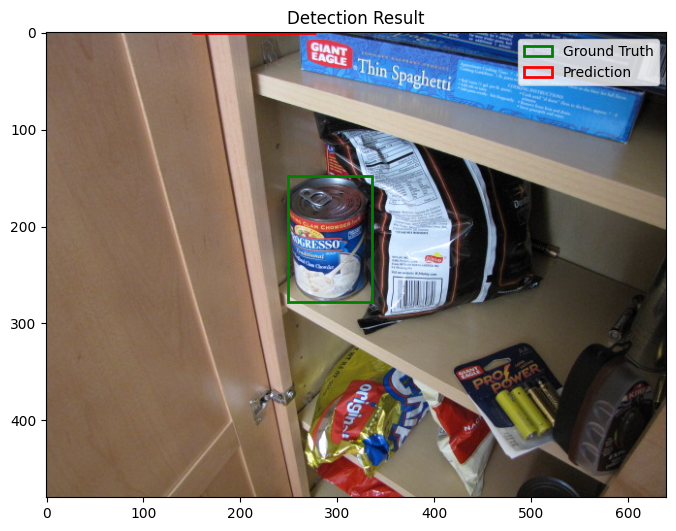

In [17]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict

# Make sure to import the tracking function from your script
from sam2_extract import track_item_boxes

# --- Helper Functions (Copied from your previous script) ---
def process_img_png_mask(image_path, mask_path):
    try:
        with Image.open(mask_path) as mask_img:
            mask = np.array(mask_img.convert('L')) > 0
        rows, cols = np.any(mask, axis=1), np.any(mask, axis=0)
        if not np.any(rows) or not np.any(cols): return None
        ymin, ymax = np.where(rows)[0][[0, -1]]
        xmin, xmax = np.where(cols)[0][[0, -1]]
        return [xmin, ymin, xmax, ymax] # Using (xmin, ymin, xmax, ymax) for clarity
    except (FileNotFoundError, Exception):
        return None

def get_bbox_from_mask(mask):
    rows, cols = np.any(mask, axis=1), np.any(mask, axis=0)
    if not np.any(rows) or not np.any(cols): return [0, 0, 0, 0]
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return [xmin, ymin, xmax, ymax]

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# --- Main Debugging Script ---
print("🚀 Starting debug script...")
dataset_path = '/content/CMU10_3D/data_2D'
all_files = os.listdir(dataset_path)
all_masks = [f for f in all_files if f.endswith('.png')]

# --- Find a valid pair to test ---
first_image_path, first_mask_path = None, None
test_image_path, test_mask_path = None, None

for img_file in sorted(f for f in all_files if f.startswith('can_chowder') and f.endswith('.jpg')):
    base_name = os.path.splitext(img_file)[0]
    found_mask = next((m for m in all_masks if m.startswith(base_name)), None)

    if found_mask:
        if first_image_path is None:
            first_image_path = os.path.join(dataset_path, img_file)
            first_mask_path = os.path.join(dataset_path, found_mask)
        else:
            test_image_path = os.path.join(dataset_path, img_file)
            test_mask_path = os.path.join(dataset_path, found_mask)
            break # We have found our two images

# --- Run the detection and visualization ---
if first_image_path and test_image_path:
    print(f"Setup Image: {os.path.basename(first_image_path)}")
    print(f"Test Image:  {os.path.basename(test_image_path)}")

    # 1. Get the initial box from the first image
    initial_bbox = process_img_png_mask(first_image_path, first_mask_path)

    # 2. Get the ground truth box for the test image
    ground_truth_box = process_img_png_mask(test_image_path, test_mask_path)

    # 3. Get the predicted box from the model
    video_segments = track_item_boxes(first_image_path, test_image_path, [([initial_bbox[0], initial_bbox[2], initial_bbox[1], initial_bbox[3]], 1)], visualize=False)
    predicted_box = [0, 0, 0, 0]
    if 1 in video_segments and 1 in video_segments[1]:
        predicted_box = get_bbox_from_mask(video_segments[1][1])

    # 4. Print the coordinates
    print(f"\\nGround Truth Box: {ground_truth_box}")
    print(f"Predicted Box:      {predicted_box}")

    # 5. Calculate and print the IoU
    iou = calculate_iou(ground_truth_box, predicted_box)
    print(f"\\nCalculated IoU: {iou:.4f}")

    # 6. Visualize the result
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(Image.open(test_image_path))
    ax.set_title("Detection Result")

    # Draw Ground Truth (Green)
    if ground_truth_box:
        (xmin, ymin, xmax, ymax) = ground_truth_box
        gt_rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth')
        ax.add_patch(gt_rect)

    # Draw Prediction (Red)
    if predicted_box != [0, 0, 0, 0]:
        (xmin, ymin, xmax, ymax) = predicted_box
        pred_rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none', label='Prediction')
        ax.add_patch(pred_rect)

    ax.legend()
    plt.show()

else:
    print("Could not find two 'can_chowder' images to test.")